# Representation Learning using Auto Encoders

In [1]:
import keras as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from sklearn.model_selection import train_test_split

2024-05-12 08:35:45.863694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 08:35:45.863786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 08:35:46.042528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Keras version:", K.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 3.2.1
TensorFlow version: 2.15.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

Num GPUs Available:  2
GPU is available


In [4]:
data = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
(X_train, y_train), (X_test, y_test) = data
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [6]:
X_train = X_train / 255
X_test = X_test / 255

In [33]:
def noising_process(input, stddev=0.1):

    noised_input = input + np.random.normal(0, stddev, input.shape)
    return np.clip(noised_input, 0.0, 1.0)

def print_imgs(real, reconstructed, num_images=10, pure_noise=False, model=None):

    if pure_noise:
        reconstructed = []
        if model is None:
            print("Model must be passed")
            return
        
    indices = np.random.choice(len(real), size=num_images, replace=False)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    axes[0, 0].set_title('Original Images', fontsize=12)
    axes[1, 0].set_title('Reconstructed Images', fontsize=12)
    
    for idx, index in enumerate(indices):
        ax1 = axes[0, idx]
        ax1.imshow(real[index].reshape(28, 28), cmap='gray')
        ax1.axis('off')

        if pure_noise:
            recon_img = convergence_to_manifold(model, real[index], verbose=0)
            reconstructed.append(recon_img)

        ax2 = axes[1, idx]
        if pure_noise:
            ax2.imshow(tf.reshape(reconstructed[idx], (28, 28)), cmap='gray')
        else:
            ax2.imshow(reconstructed[index].reshape(28, 28), cmap='gray')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

def convergence_to_manifold(model, target_image, max_iter=1000, eps=1e-5, verbose=2):

    previous_loss = None

    target = tf.convert_to_tensor(target_image, dtype=np.float32)
    noised_image = tf.Variable(initial_value=tf.reshape(np.random.normal(0, 1, (28, 28)).astype(np.float32), shape=(1, 28, 28)), trainable=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.01)

    for iteration in range(max_iter):

        with tf.GradientTape() as g:
            g.watch(noised_image)
            reconstruction = model(noised_image)
            loss = tf.reduce_sum(tf.square(reconstruction - target))  # to maximize similarity through MSE

        # Compute gradients and apply them through the optimizer
        gradients = g.gradient(loss, [noised_image])
        optimizer.apply_gradients(zip(gradients, [noised_image]))

        current_loss = loss.numpy()

        if iteration % 1000 == 0 and verbose > 1:
            print(f'iteration: {iteration}, loss: {current_loss}')

        if previous_loss is not None and abs(previous_loss - current_loss) < eps and verbose > 1:
            print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
            break
        
        if iteration == max_iter - 1 and verbose> 0:
            print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

        previous_loss = current_loss
        
    return reconstruction

In [8]:
inputs = K.Input((28, 28))
x = K.layers.Flatten()(inputs)
x = K.layers.Dense(1024, activation='relu')(x)
x = K.layers.Dense(784, activation='sigmoid')(x)
outputs = K.layers.Reshape((28, 28)) (x)
model = K.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'binary_crossentropy']
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Let's first see if the model is good enough to learn the identity function:

In [11]:
model.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/20
 50/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.4156 - loss: 0.1025 - mean_squared_error: 0.1025

I0000 00:00:1715461788.193651     183 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715461788.208600     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_crossentropy: 0.2698 - loss: 0.0394 - mean_squared_error: 0.0394

W0000 00:00:1715461790.196816     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715461790.987806     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_crossentropy: 0.2697 - loss: 0.0394 - mean_squared_error: 0.0394 - val_binary_crossentropy: 0.1381 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2/20
 56/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1383 - loss: 0.0068 - mean_squared_error: 0.0068

W0000 00:00:1715461791.452637     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_crossentropy: 0.1323 - loss: 0.0061 - mean_squared_error: 0.0061 - val_binary_crossentropy: 0.1134 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1118 - loss: 0.0041 - mean_squared_error: 0.0041 - val_binary_crossentropy: 0.0994 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.0991 - loss: 0.0031 - mean_squared_error: 0.0031 - val_binary_crossentropy: 0.0898 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.0908 - loss: 0.0024 - mean_squared_error: 0.0024 - val_binary_crossentropy: 0.0845 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_crossentropy: 0.0845 - loss: 0.0020 - mean_squared_error: 0.0020 - val_binary_crossentropy: 0.0803 - v

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


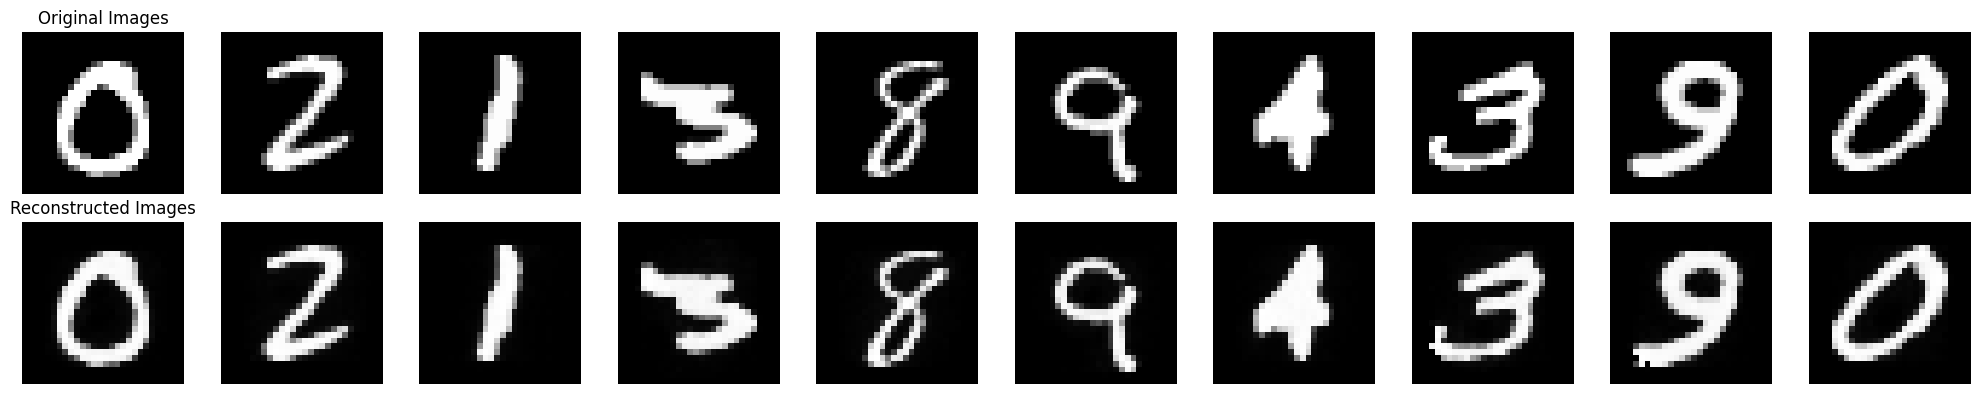

In [12]:
predictions = model.predict(X_test)
print_imgs(X_test, predictions)

Now let's see if it learns the distributiono using the noised version of the input (we'll start by a small gaussian noise, i.e. one with stddev=0.1):

In [13]:
model.fit(
    noising_process(X_train, 0.1),
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.1), X_test),
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_crossentropy: 0.0739 - loss: 0.0021 - mean_squared_error: 0.0021 - val_binary_crossentropy: 0.0704 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.0707 - loss: 0.0016 - mean_squared_error: 0.0016 - val_binary_crossentropy: 0.0698 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.0697 - loss: 0.0015 - mean_squared_error: 0.0015 - val_binary_crossentropy: 0.0694 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.0695 - loss: 0.0014 - mean_squared_error: 0.0014 - val_binary_crossentropy: 0.0692 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.0693 - loss: 0.0014 - mean_squared_error: 0.0014 - val_binary_crossentropy:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


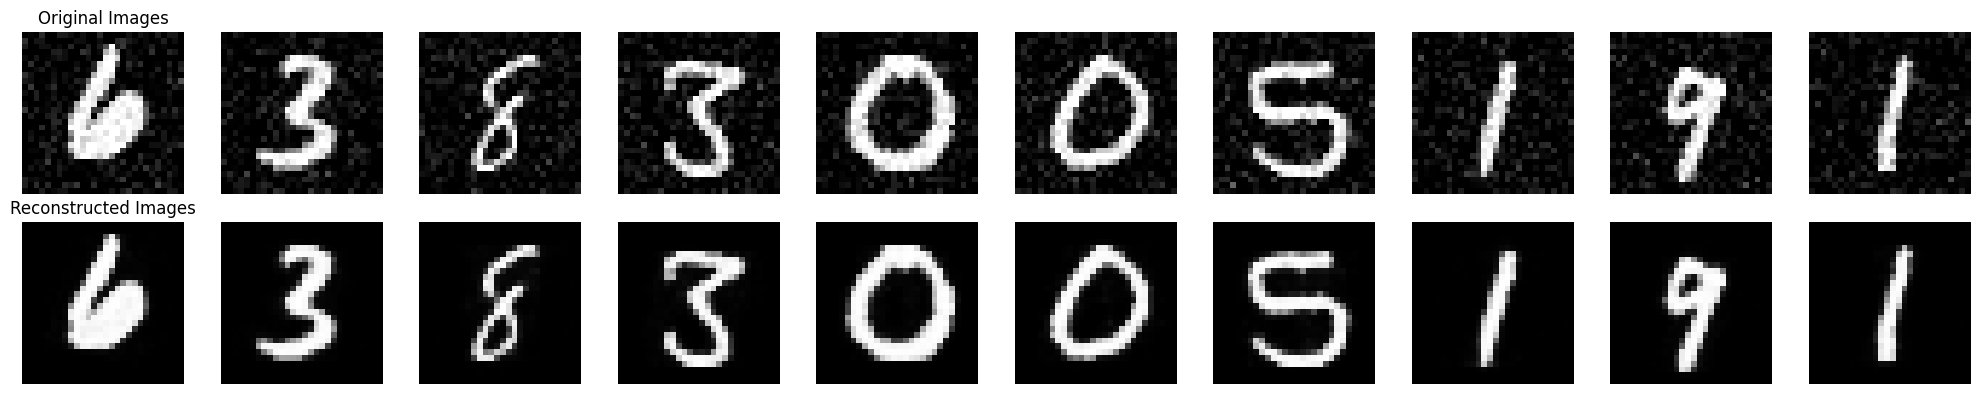

In [14]:
noised_data = noising_process(X_test, 0.1)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


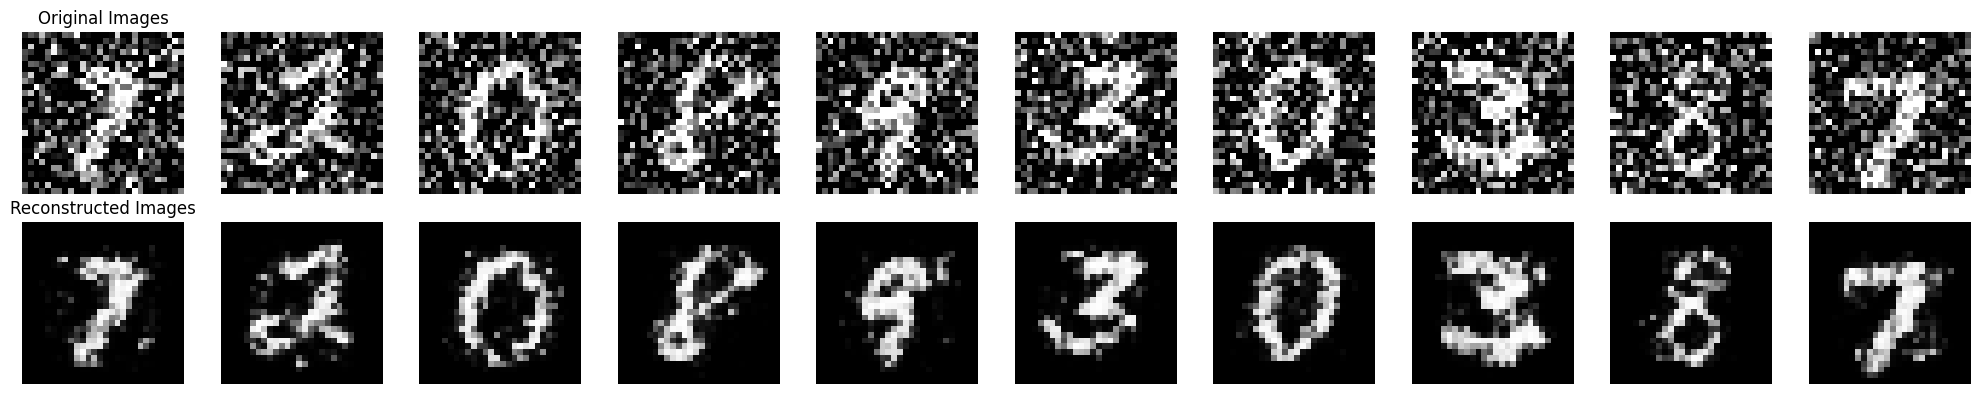

In [15]:
noised_data = noising_process(X_test, 0.5)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

Since the model struggles a bit to reconstruct images with stronger noise, we will retrain it using more disturbed images

In [9]:
inputs = K.Input((28, 28))
x = K.layers.Flatten()(inputs)
x = K.layers.Dense(1024, activation='relu')(x)
x = K.layers.Dense(784, activation='sigmoid')(x)
outputs = K.layers.Reshape((28, 28)) (x)
model = K.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'binary_crossentropy']
)

early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

model.fit(
    noising_process(X_train, 0.5),
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.5), X_test),
    callbacks=[early_stopping]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
 46/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.4276 - loss: 0.1040 - mean_squared_error: 0.1040

I0000 00:00:1715500186.064377     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715500186.079397     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.3130 - loss: 0.0503 - mean_squared_error: 0.0503

W0000 00:00:1715500188.402194     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715500189.240276     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - binary_crossentropy: 0.3129 - loss: 0.0503 - mean_squared_error: 0.0503 - val_binary_crossentropy: 0.1421 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1314 - loss: 0.0179 - mean_squared_error: 0.0179 - val_binary_crossentropy: 0.1142 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1128 - loss: 0.0149 - mean_squared_error: 0.0149 - val_binary_crossentropy: 0.1096 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1085 - loss: 0.0138 - mean_squared_error: 0.0138 - val_binary_crossentropy: 0.1076 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1055 - loss: 0.0129 - mean_squared_error: 0.0129 - val_binary_crossentropy: 0.1057 - v

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


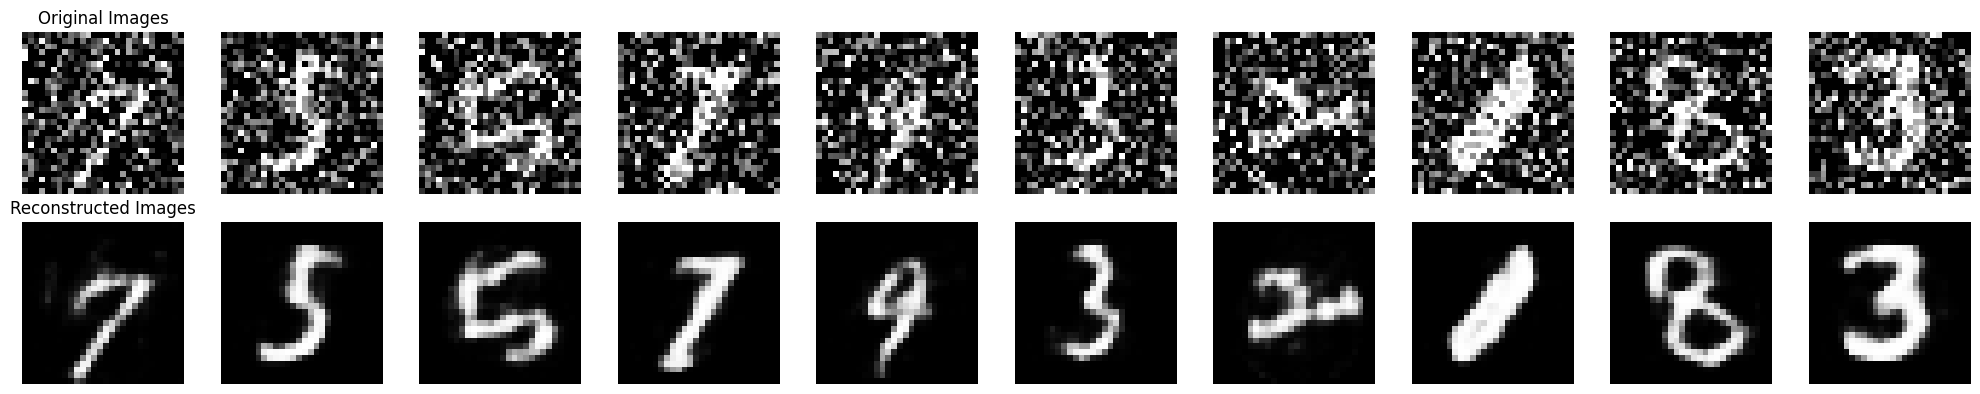

In [10]:
noised_data = noising_process(X_test, 0.5)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

In [11]:
noisy_test = noising_process(X_test, 0.5)
predictions = model.predict(noisy_test)
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(X_test, predictions).numpy()

print(f'Reconstruction error: {reconstruction_error}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction error: 0.012592040002346039


and as we can see, the model actually does a better job at reconstructing strong-noised images (in this case gaussian noise with 0.5 stddev)

Now we will observe what happens if we follow the gradient of the probability function

First, we will look at what happens when starting from a real image to which we add some noise (following the gradient must result in a very precise result of the digit)

In [27]:
reconstruction = convergence_to_manifold(X_test[3])

iteration: 0, loss: 125.41403198242188
Not converged. Last iteration 999 w/ loss: 0.523093581199646 and epsilon: 0.0003876686096191406


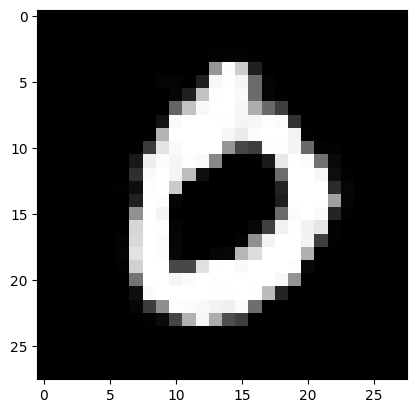

In [28]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

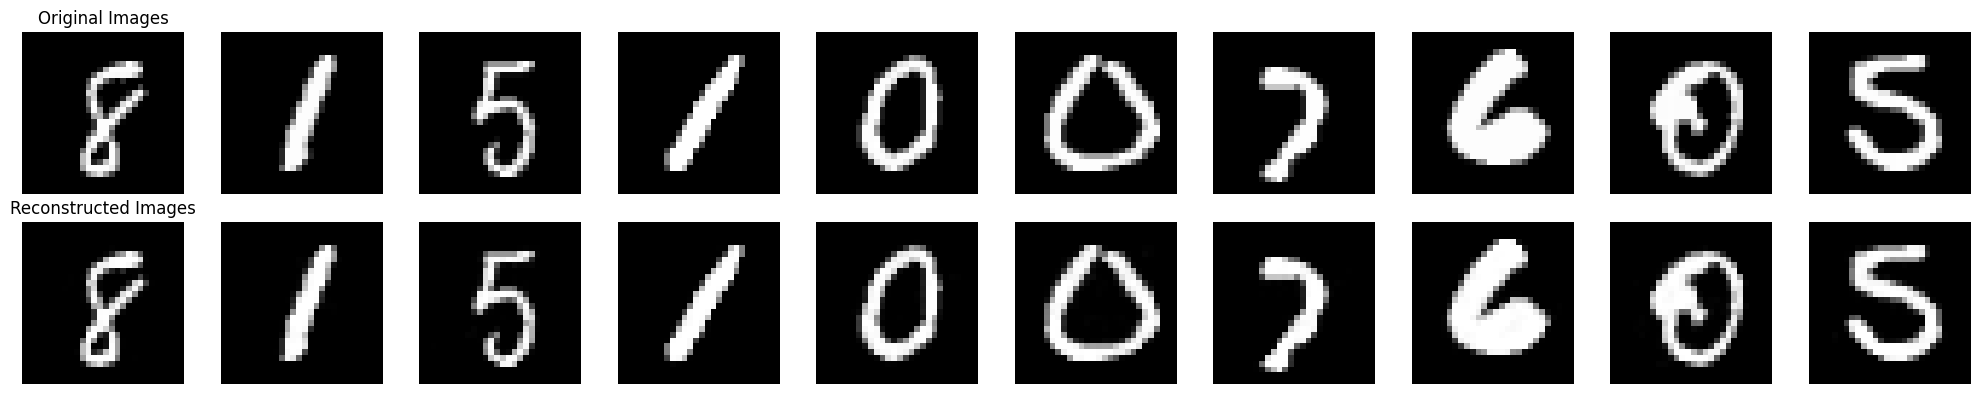

In [50]:
print_imgs(X_test, None, num_images=10, pure_noise=True)

it seems like the reconstruction is converging to the data manifold, but the hidden representation might not be adequate.

## Unsupervised layerwise pretraining
In the following, we are going to see if performance increases when stacking auto-encoder, i.e. using a deep-AE.

To do so, we will train each auto-encoder separately, starting from the input data. The auto-encoders following the first one will take as input the previous encoder's representation. Thus at each training step the decoder will be discarded, up until the last layer.

In [8]:
def create_autoencoder(input_dim, encoding_dim):
    input_layer = K.Input(shape=(input_dim,))
    encoder_layer = K.layers.Dense(encoding_dim, activation='relu')(input_layer)
    decoder_layer = K.layers.Dense(input_dim, activation='sigmoid')
    decoder_output = decoder_layer(encoder_layer)
    
    autoencoder = K.Model(input_layer, decoder_output)
    encoder = K.Model(input_layer, encoder_layer)
    
    decoder_input = K.Input(shape=(encoding_dim,))
    decoder_output = decoder_layer(decoder_input)
    decoder = K.Model(decoder_input, decoder_output)
    
    autoencoder.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    
    return autoencoder, encoder, decoder

def layerwise_pretraining(data, layers, noise_level=0.5, epochs=20):
    encoders = []
    decoders = []
    inputs = data
    
    for i, (input_dim, encoding_dim) in enumerate(zip(layers[:-1], layers[1:])):
        early_stopping = K.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0001,
            patience=5,
            verbose=1,
            restore_best_weights=True)
        print(f"Training layer {i+1}/{len(layers)-1}")
        print(f'creating ae #{i} with input_dim:{input_dim}, encoding_dim:{encoding_dim}')

        noisy_inputs = noising_process(inputs, noise_level)
        
        autoencoder, encoder, decoder = create_autoencoder(input_dim, encoding_dim)
        autoencoder.summary()
        
        autoencoder.fit(
            noisy_inputs,
            inputs,
            epochs=epochs,
            batch_size=128,
            shuffle=True,
            validation_split=0.2,
            callbacks=[early_stopping]
        )
    
        inputs = encoder(noisy_inputs)
        encoders.append(encoder)
        decoders.append(decoder)
        
    return encoders, decoders

In [9]:
X_train_reshaped = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test_reshaped = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [16]:
layer_sizes = [784, 1024, 1024]
encoders, decoders = layerwise_pretraining(X_train_reshaped, layer_sizes, epochs=50)

Training layer 1/2
creating ae #0 with input_dim:784, encoding_dim:1024


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
 68/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0921  

W0000 00:00:1715503197.099023     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


354/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0552

W0000 00:00:1715503198.315968     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0541 - val_loss: 0.0223
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0199 - val_loss: 0.0165
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143 - val_loss: 0.0146
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128 - val_loss: 0.0138
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0122 - val_loss: 0.0135
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0134
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0133
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - val_loss: 0.0132
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0106 - val_loss: 0.0131
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     1,049,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,200 (8.01 MB)

 Trainable params: 2,099,200 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2253 - val_loss: 0.1581
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1557 - val_loss: 0.1487
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1484 - val_loss: 0.1454
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1450 - val_loss: 0.1437
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1431 - val_loss: 0.1427
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1419 - val_loss: 0.1423
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1409 - val_loss: 0.1417
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1409 - val_loss: 0.1415
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1402 - val_loss: 0.1413
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1396 - val_loss: 0.1411
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1396 - val_loss: 0.1408
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [17]:
stacked_ae = K.Sequential()
stacked_ae.add(K.Input((28, 28)))
stacked_ae.add(K.layers.Flatten())
for encoder in encoders:
    stacked_ae.add(encoder.layers[1])
    
for decoder in decoders[::-1]:
    stacked_ae.add(decoder.layers[1])
    
stacked_ae.add(K.layers.Reshape((28, 28)))
    
stacked_ae.compile(
    optimizer='adam',
    loss='mean_squared_error'
)
stacked_ae.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,640 (14.14 MB)

 Trainable params: 3,706,640 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

115/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1715503236.924062     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


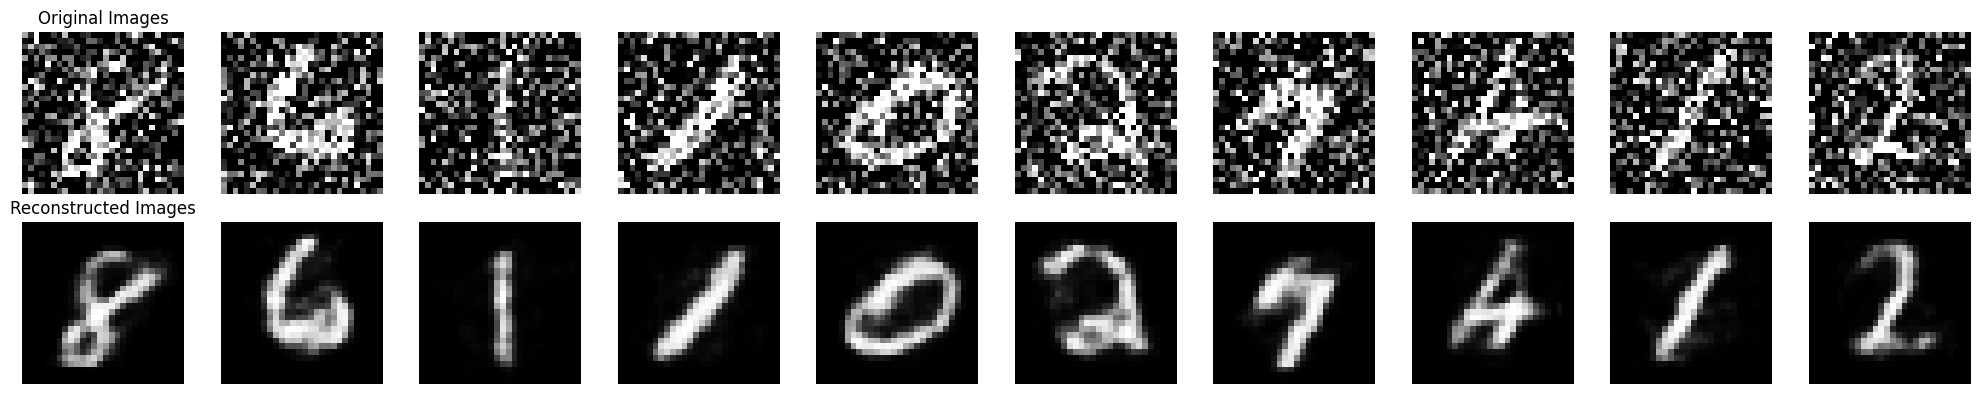

In [18]:
noised_data = noising_process(X_test, 0.5)

predictions = stacked_ae.predict(noised_data)
print_imgs(noised_data, predictions)

In [19]:
noisy_test = noising_process(X_test, 0.5)
predictions = stacked_ae.predict(noisy_test)
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(X_test, predictions).numpy()

print(f'Reconstruction error post pre-training: {reconstruction_error}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction error post pre-training: 0.017594516277313232


In [20]:
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

stacked_ae.fit(
    noising_process(X_train, 0.5),
    X_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
 42/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172

W0000 00:00:1715503243.541289     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


362/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152

W0000 00:00:1715503245.299161     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0152 - val_loss: 0.0140
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0135
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0132
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0131
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - val_loss: 0.0130
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0130
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0130
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - val_loss: 0.0131
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0132
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


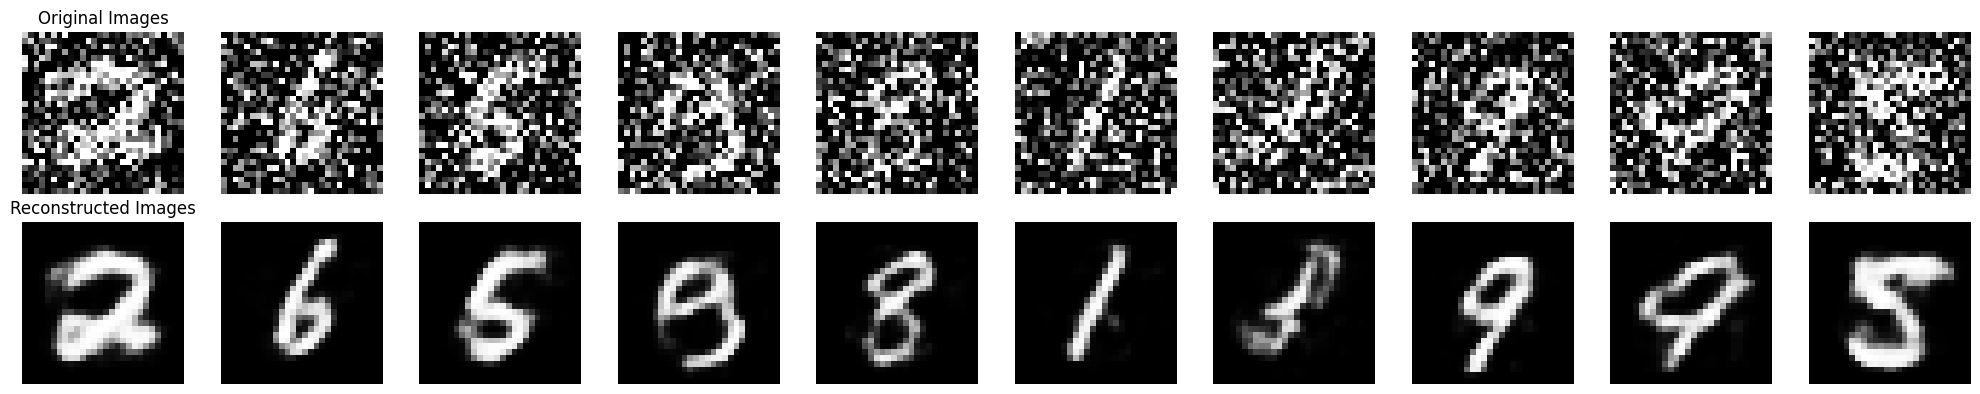

In [23]:
noised_data = noising_process(X_test, 0.6)

predictions = stacked_ae.predict(noised_data).reshape((-1, 28, 28))
print_imgs(noised_data, predictions)

In [24]:
noisy_test = noising_process(X_test, 0.5)
predictions = stacked_ae.predict(noisy_test)
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(X_test, predictions).numpy()

print(f'Reconstruction error post fine-tuning: {reconstruction_error}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction error post fine-tuning: 0.012796731665730476


In [29]:
reconstruction = convergence_to_manifold(stacked_ae, X_test[0])

iteration: 0, loss: 53.859622955322266
Not converged. Last iteration 999 w/ loss: 0.8715183734893799 and epsilon: 0.00020807981491088867


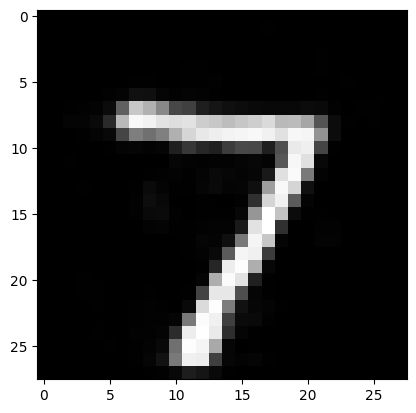

In [30]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

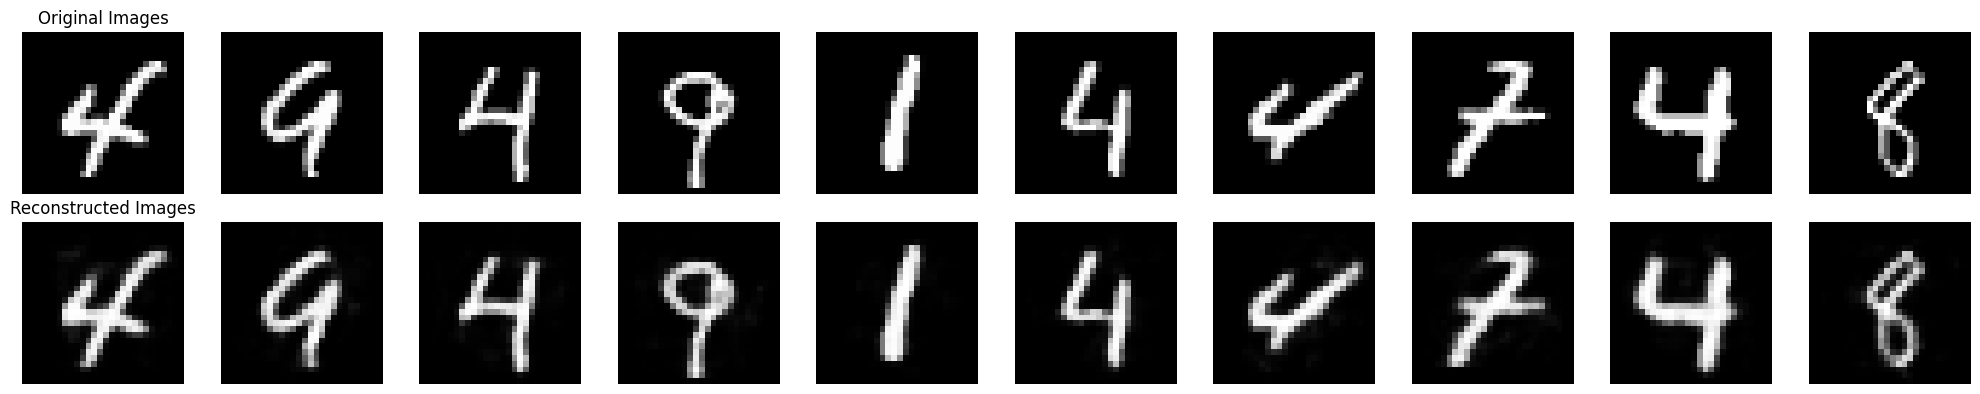

In [34]:
print_imgs(X_test, None, num_images=10, pure_noise=True, model=stacked_ae)

# More hidden layers

In [91]:
inputs = K.Input((28, 28))
x = K.layers.Flatten()(inputs)
x = K.layers.Dense(256, activation='relu')(x)
x = K.layers.Dense(256, activation='relu')(x)
x = K.layers.Dense(784, activation='sigmoid')(x)
outputs = K.layers.Reshape((28, 28)) (x)
model = K.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'binary_crossentropy']
)

early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

model.fit(
    noising_process(X_train, 0.5),
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.5), X_test),
    callbacks=[early_stopping]
)

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 784)            │       201,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,240 (1.79 MB)

 Trainable params: 468,240 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - binary_crossentropy: 0.3096 - loss: 0.0641 - mean_squared_error: 0.0641 - val_binary_crossentropy: 0.1425 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 2/20
 56/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1426 - loss: 0.0238 - mean_squared_error: 0.0238

W0000 00:00:1715465281.028542     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1372 - loss: 0.0224 - mean_squared_error: 0.0224 - val_binary_crossentropy: 0.1238 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1231 - loss: 0.0185 - mean_squared_error: 0.0185 - val_binary_crossentropy: 0.1187 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1172 - loss: 0.0169 - mean_squared_error: 0.0169 - val_binary_crossentropy: 0.1151 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1140 - loss: 0.0159 - mean_squared_error: 0.0159 - val_binary_crossentropy: 0.1125 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1117 - loss: 0.0152 - mean_squared_error: 0.0152 - val_binary_crossentropy: 0.1110 - v

132/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1715465315.399037     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


W0000 00:00:1715465315.867224     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


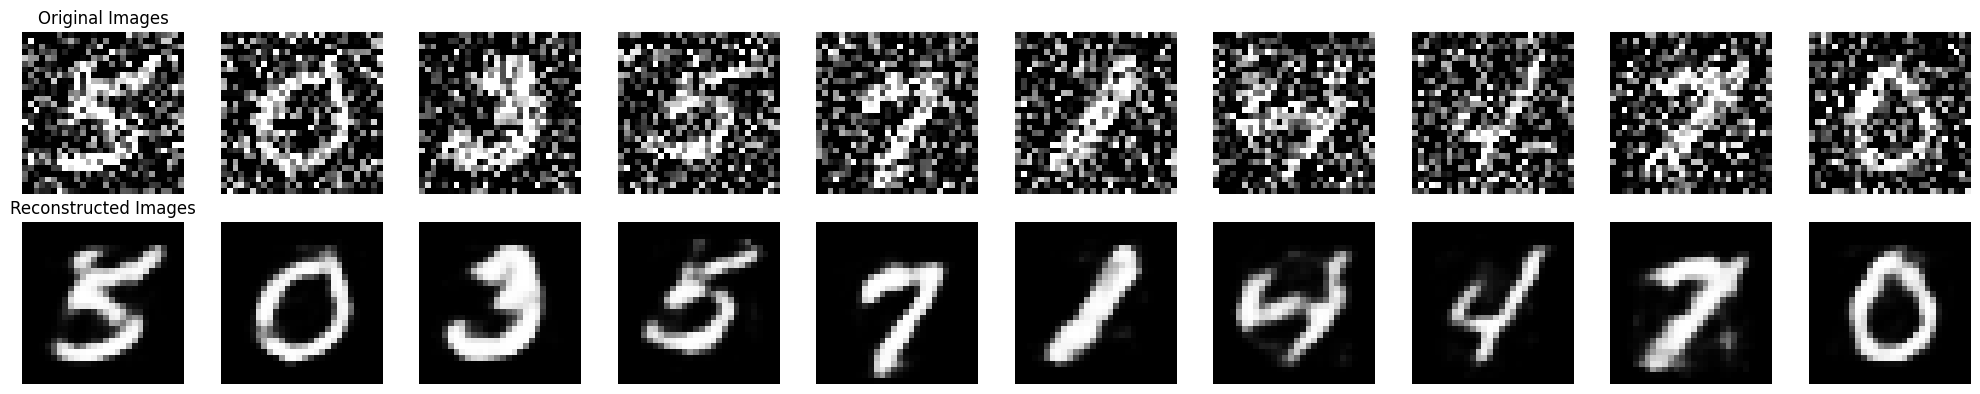

In [92]:
noised_data = noising_process(X_test, 0.5)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

In [93]:
noisy_test = noising_process(X_test, 0.5)
predictions = model.predict(noisy_test)
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(X_test, predictions).numpy()

print(f'Reconstruction error: {reconstruction_error}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction error: 0.013360106386244297


In [94]:
max_iter = 5000
epsilon = 1e-16
previous_loss = None

noised_image = tf.Variable(initial_value=tf.reshape(np.random.normal(0, 1, (28, 28)).astype(np.float32), shape=(1, 28, 28)), trainable=True)
optimizer = tf.optimizers.Adam(learning_rate=0.01)

for iteration in range(max_iter):

    with tf.GradientTape() as g:
        g.watch(noised_image)
        reconstruction = model(noised_image)
        loss = tf.reduce_sum(tf.square(reconstruction - noised_image))  # to maximize similarity through MSE

    # Compute gradients and apply them through the optimizer
    gradients = g.gradient(loss, [noised_image])
    optimizer.apply_gradients(zip(gradients, [noised_image]))

    current_loss = loss.numpy()

    if iteration % 1000 == 0:
        print(f'iteration: {iteration}, loss: {current_loss}')

    if iteration == max_iter - 1:
        print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

    if previous_loss is not None and abs(previous_loss - current_loss) < epsilon:
        print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
        break

    previous_loss = current_loss

iteration: 0, loss: 742.147216796875
iteration: 1000, loss: 0.002400206634774804
iteration: 2000, loss: 2.3880169464973733e-05
iteration: 3000, loss: 5.397338100010529e-06
iteration: 4000, loss: 2.2677568267681636e-06
Not converged. Last iteration 4999 w/ loss: 6.649355555055081e-07 and epsilon: -6.2090066421660595e-09


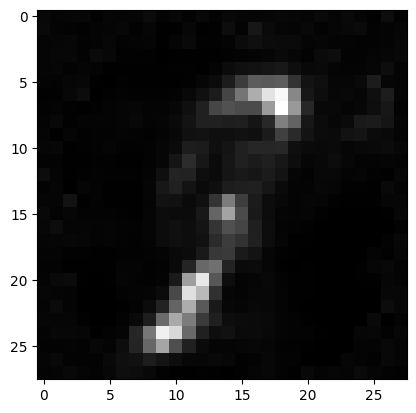

In [95]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

## Using a U-Shaped CNN as encoder-decoder structure
Since we are dealing with images, we will now see whether using a U-Shaped CNN gives us any conspicuous advantage. We will restrict ourselves to just explore a simple structure of two convolutions/deconvolutions (where we will use maxpooling to downsample and a strided deconvolution to upsample).

In [65]:
conv_inputs = K.Input(shape=((28, 28, 1)))
x_conv = K.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_inputs)
x_conv = K.layers.MaxPooling2D((2,2))(x_conv)
x_conv = K.layers.Conv2D(128, (3,3), activation='relu', padding='same')(x_conv)
x_conv = K.layers.MaxPooling2D((2,2))(x_conv)

x_conv = K.layers.Conv2DTranspose(128, (3,3), strides=2, padding='same')(x_conv)
x_conv = K.layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(x_conv)
conv_outputs = K.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x_conv)

conv_model = K.Model(inputs=conv_inputs, outputs=conv_outputs)

conv_model.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,449 (1.13 MB)

 Trainable params: 296,449 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
conv_model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

In [67]:
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

conv_model.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.1198 - val_loss: 0.1140
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


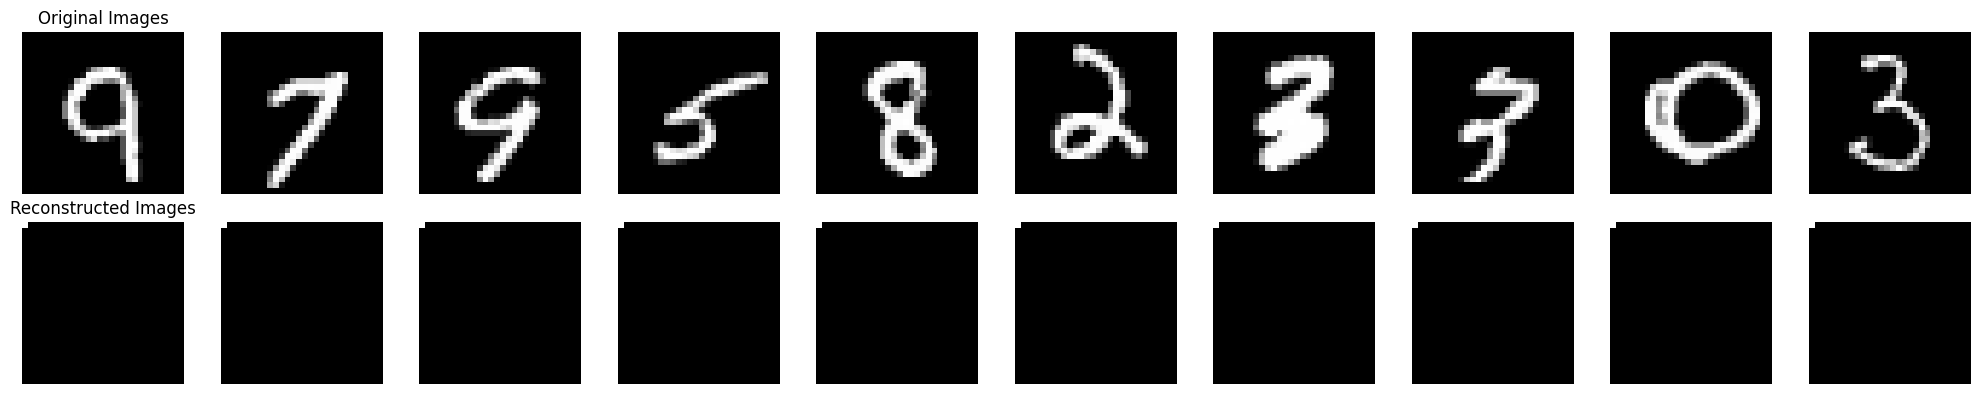

In [68]:
predictions = conv_model.predict(X_test)
print_imgs(X_test, predictions)

In [69]:
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

conv_model.fit(
    noising_process(X_train, 0.5),
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.5), X_test),
    callbacks=[early_stopping]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [70]:
noisy_test = noising_process(X_test, 0.5)
predictions = conv_model.predict(noisy_test)
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(X_test, predictions).numpy()

print(f'Reconstruction error post pre-training: {reconstruction_error}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Reconstruction error post pre-training: 0.11395810544490814


The model is able to reconstruct the images even when using some intensive noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


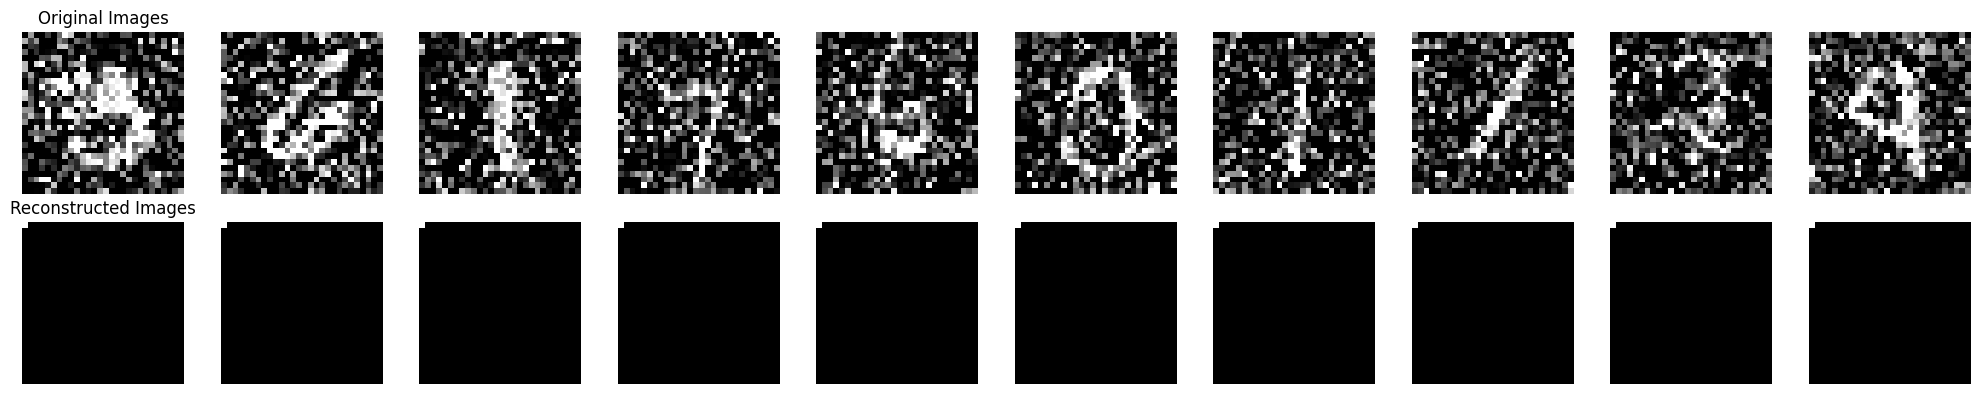

In [71]:
noised_data = noising_process(X_test, 0.5)

predictions = conv_model.predict(noised_data)
print_imgs(noised_data, predictions)

In [72]:
max_iter = 5000
epsilon = 1e-16
previous_loss = None

# Initialize the noised image as a trainable variable
noised_image = tf.Variable(initial_value=tf.reshape(np.random.normal(0, 1, (28, 28)).astype(np.float32), shape=(1, 28, 28, 1)), trainable=True)

# Initialize the Adam optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

for iteration in range(max_iter):

    with tf.GradientTape() as g:
        g.watch(noised_image)
        reconstruction = conv_model(noised_image)
        loss = tf.reduce_sum(tf.square(reconstruction - noised_image))  # to maximize similarity through MSE

    # Compute gradients and apply them through the optimizer
    gradients = g.gradient(loss, [noised_image])
    optimizer.apply_gradients(zip(gradients, [noised_image]))

    current_loss = loss.numpy()

    if iteration % 1000 == 0:
        print(f'iteration: {iteration}, loss: {current_loss}')

    if iteration == max_iter - 1:
        print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

    if previous_loss is not None and abs(previous_loss - current_loss) < epsilon:
        print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
        break

    previous_loss = current_loss

iteration: 0, loss: 801.9005126953125
iteration: 1000, loss: 1.0334711078030523e-05
iteration: 2000, loss: 5.365376476440531e-10
iteration: 3000, loss: 9.090979801840149e-06
iteration: 4000, loss: 1.2361047083686572e-06
Not converged. Last iteration 4999 w/ loss: 5.231621003076725e-07 and epsilon: -4.345270383510069e-07


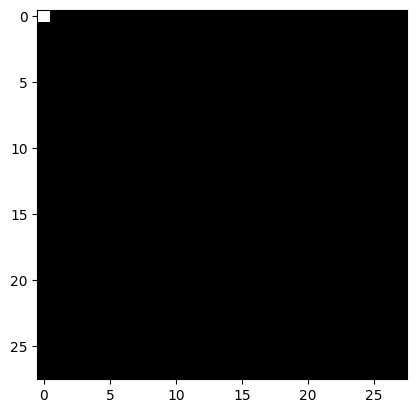

In [73]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()